# Walmart : Triptype Classification

<img src="data/walmart.jpg">

# [ Overview ]

### (1) Objective : 
> ### 각 고객의 구매정보에 따른 구매 건의 Type을 분류

### (2) Data : 
### train : 647054 rows, 7 columns
| Index 	| Feature               	| Description                                  	|
|-------	|-----------------------	|----------------------------------------------	|
| 1     	| TripType              	| Target                                       	|
| 2     	| VisitNumber           	| 각 손님의 Index                              	|
| 3     	| Weekday               	| VisitNumber가 발생한 요일                    	|
| 4     	| Upc                   	| 구매한 제품의 고유한 바코드                  	|
| 5     	| ScanCount             	| 구매 수량 ( 반품 시 `-` 값으로 표기 )        	|
| 6     	| DepartmentDescription 	| 제품의 대분류                                	|
| 7     	| FinelineNumber        	| 월마트 자체적으로 정의 한 제품의 소분류 코드 	|

### (3) _UPC code description_
- Check Digit : 숫자가 정확하게 구성되어 있는가를 보장해주는 컴퓨터 검증 숫자. UPC의 신뢰도를 검증

<img src="data/upc.png">



<br>

### test : 653646 rows, 6 columns
- 타겟값 TripType을 제외한 동일한 특성의 컬럼


<br>

### (4) Evaluation : 
> ### Multi-class log loss
> $$-\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij})$$
- $N$ : the number of visits in the test set
- $M$ : the number of trip types
- $\log$ : natural logarithm
- $y_{ij}$ : 1 if observation i is of class j and 0 otherwise
- $p_{ij}$ : the predicted probability that observation i belongs to class j

# [ Result ]: 
> #### - 참가 팀 : 총 1047 팀 
> #### - 최종 점수 : 0.777
> #### - 캐글 등수 : 292등 (상위 28%)


# [ Approach ]:
> #### - 주어진 컬럼을 통한 Feature Engineering
    - UPC decoding
    - ScanCount seperation
    - Feature encoding
    - Dummy variables
    - Identifing the most frequently purchased items per VisitNumber
    
> #### - XGBoost

* * * *

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from walmart_utils import *

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# [ EDA ]

In [2]:
train.tail()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0
647053,8,191347,Sunday,3.800060e+09,1,GROCERY DRY GOODS,3600.0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [4]:
train.describe()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,647054.000000,647054.000000,6.429250e+05,647054.000000,642925.000000
mean,58.584511,96167.640078,3.060698e+10,1.108878,3726.884567
std,157.635533,55545.485154,9.120134e+10,0.700776,2780.966158
min,3.000000,5.000000,8.340000e+02,-12.000000,0.000000
25%,27.000000,49268.000000,3.400001e+09,1.000000,1404.000000
50%,39.000000,97074.000000,7.050103e+09,1.000000,3352.000000
75%,40.000000,144316.000000,3.006531e+10,1.000000,5501.000000
max,999.000000,191347.000000,9.789707e+11,71.000000,9998.000000


## Train Data

### Most Frequent Weekday

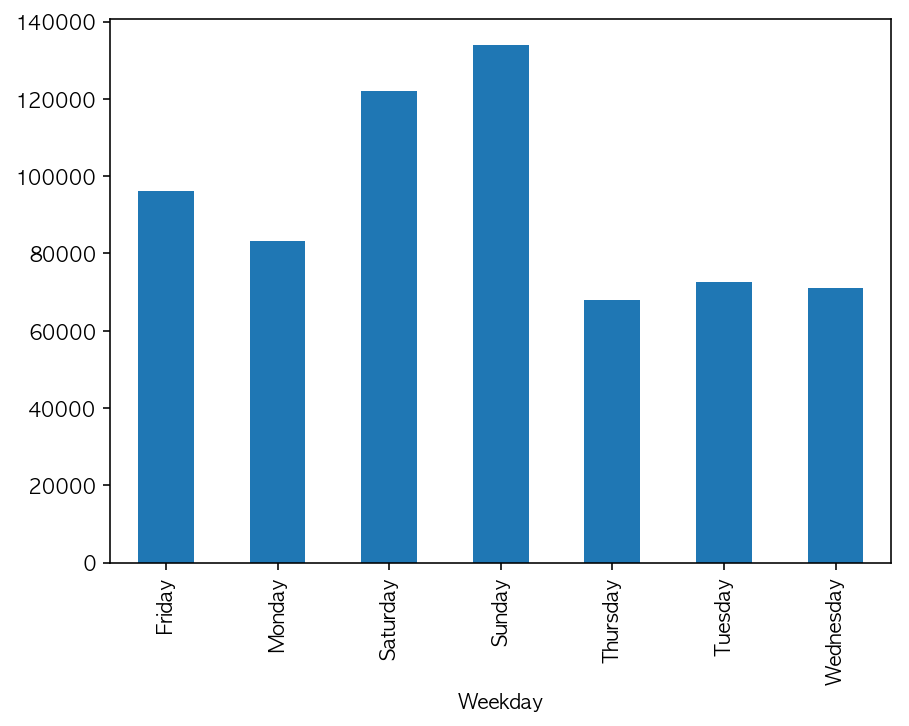

In [20]:
# Plot total number of Weekday
plt.figure(figsize=(7, 5))
train.groupby(['Weekday']).size().plot('bar')
plt.show()

#### *Missing Values*

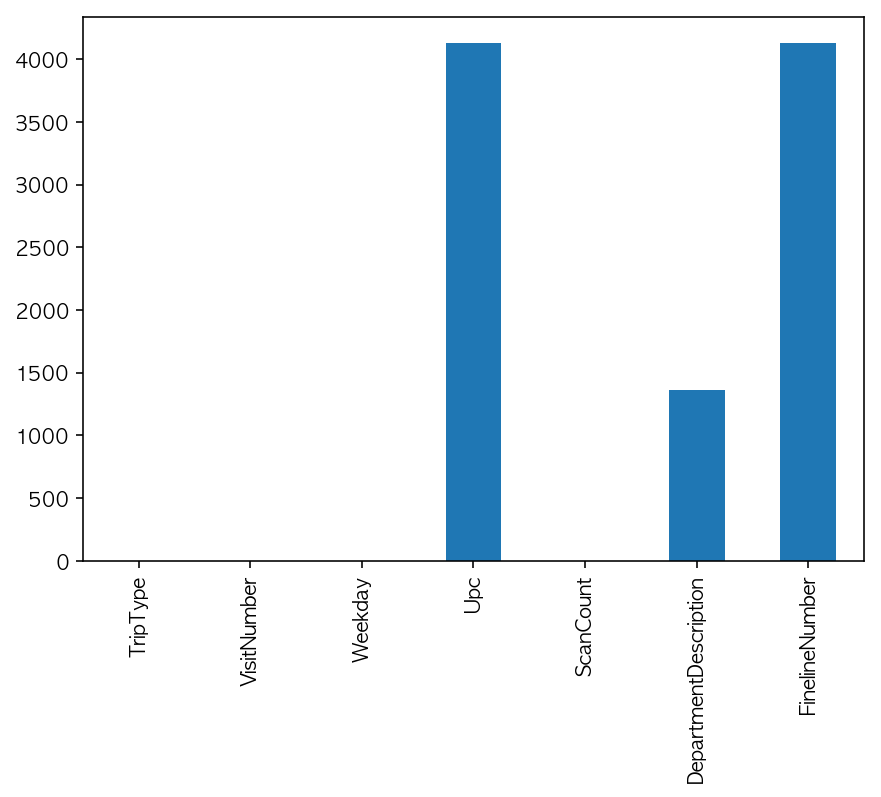

In [5]:
plt.figure(figsize=(7, 5))
train.isnull().sum().plot(kind='bar')
plt.show()

- Upc, DepartmentDescription, FinelineNumber에 Missing Values 존재
- Upc와 FinelineNumber의 Missing Values는 동시에 나타남


- Missing Value 제거 시 사라지는 VisitNumber 존재
- Feature Engineering에서 VisitNumber에 대한 테이블로 변경 $\rightarrow$ 따로 처리하지 않음

### TripType의 출현이 균등하지 않음

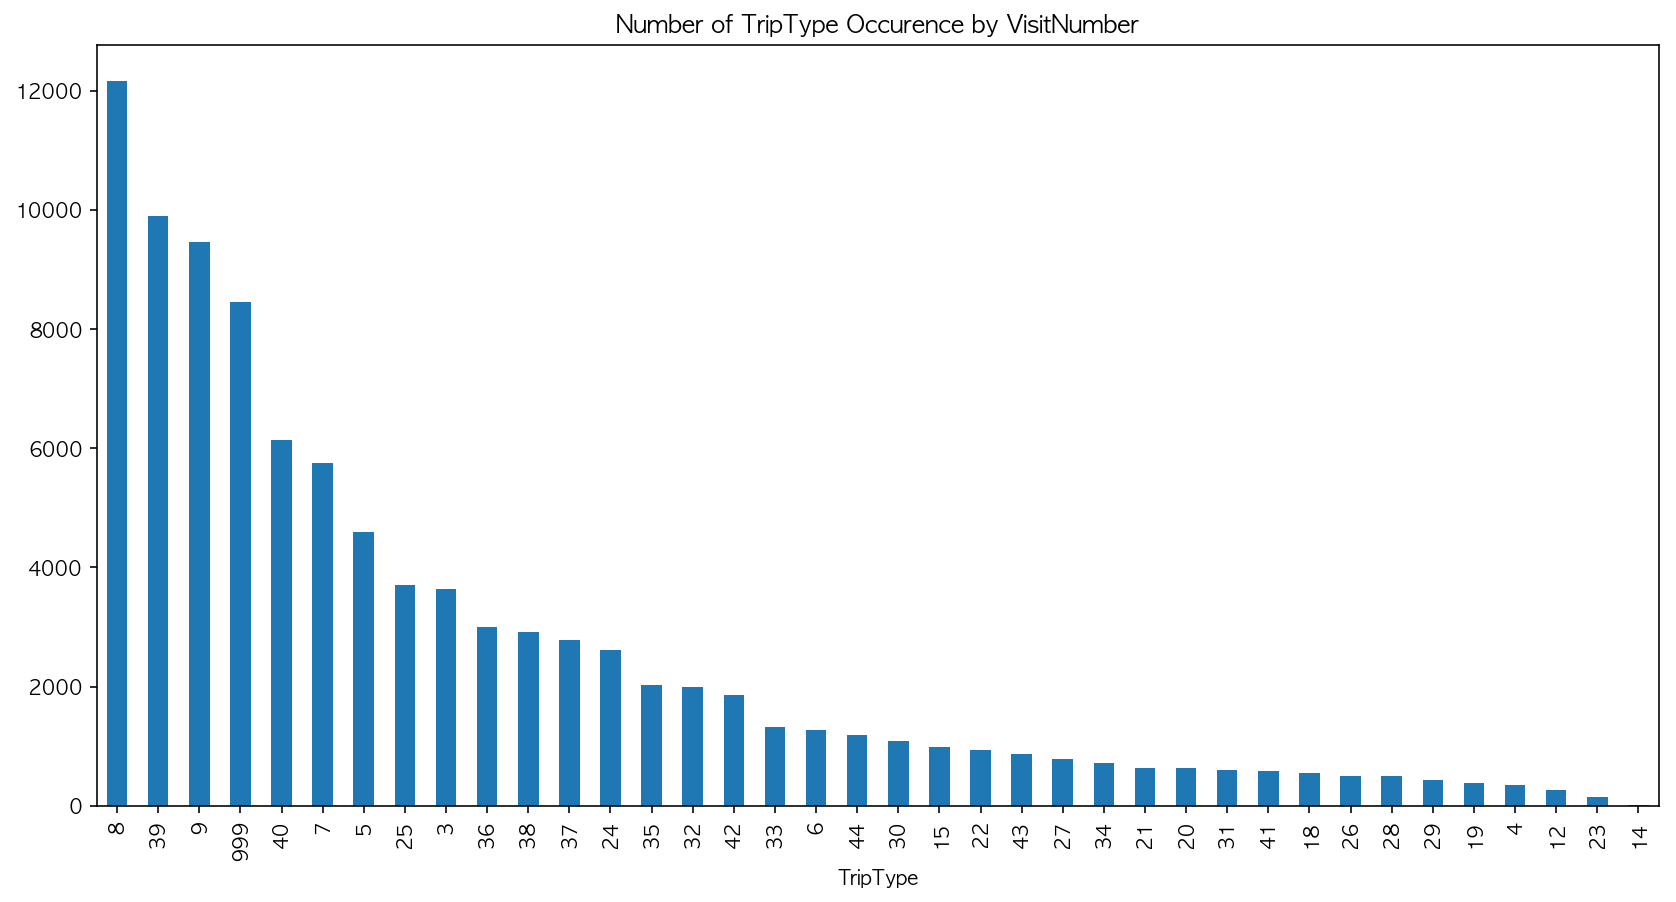

In [13]:
plt.figure(figsize=(14, 7))

np.sort(train.TripType.unique())
train_triptypes = train.drop_duplicates("VisitNumber")
a = train_triptypes["TripType"]
a = a.value_counts()
a.plot(kind='bar')
plt.title("Number of TripType Occurence by VisitNumber")
plt.xlabel("TripType")

plt.show()

In [7]:
train_40 = train[train["TripType"]==40]
train_40["DepartmentDescription"].value_counts()[:10]

GROCERY DRY GOODS           32639
DSD GROCERY                 22157
DAIRY                       17354
PRODUCE                     16704
PERSONAL CARE                9911
FROZEN FOODS                 9307
HOUSEHOLD CHEMICALS/SUPP     8093
COMM BREAD                   5968
HOUSEHOLD PAPER GOODS        5712
PHARMACY OTC                 4569
Name: DepartmentDescription, dtype: int64

### Most Frequent & Least Frequent TripType

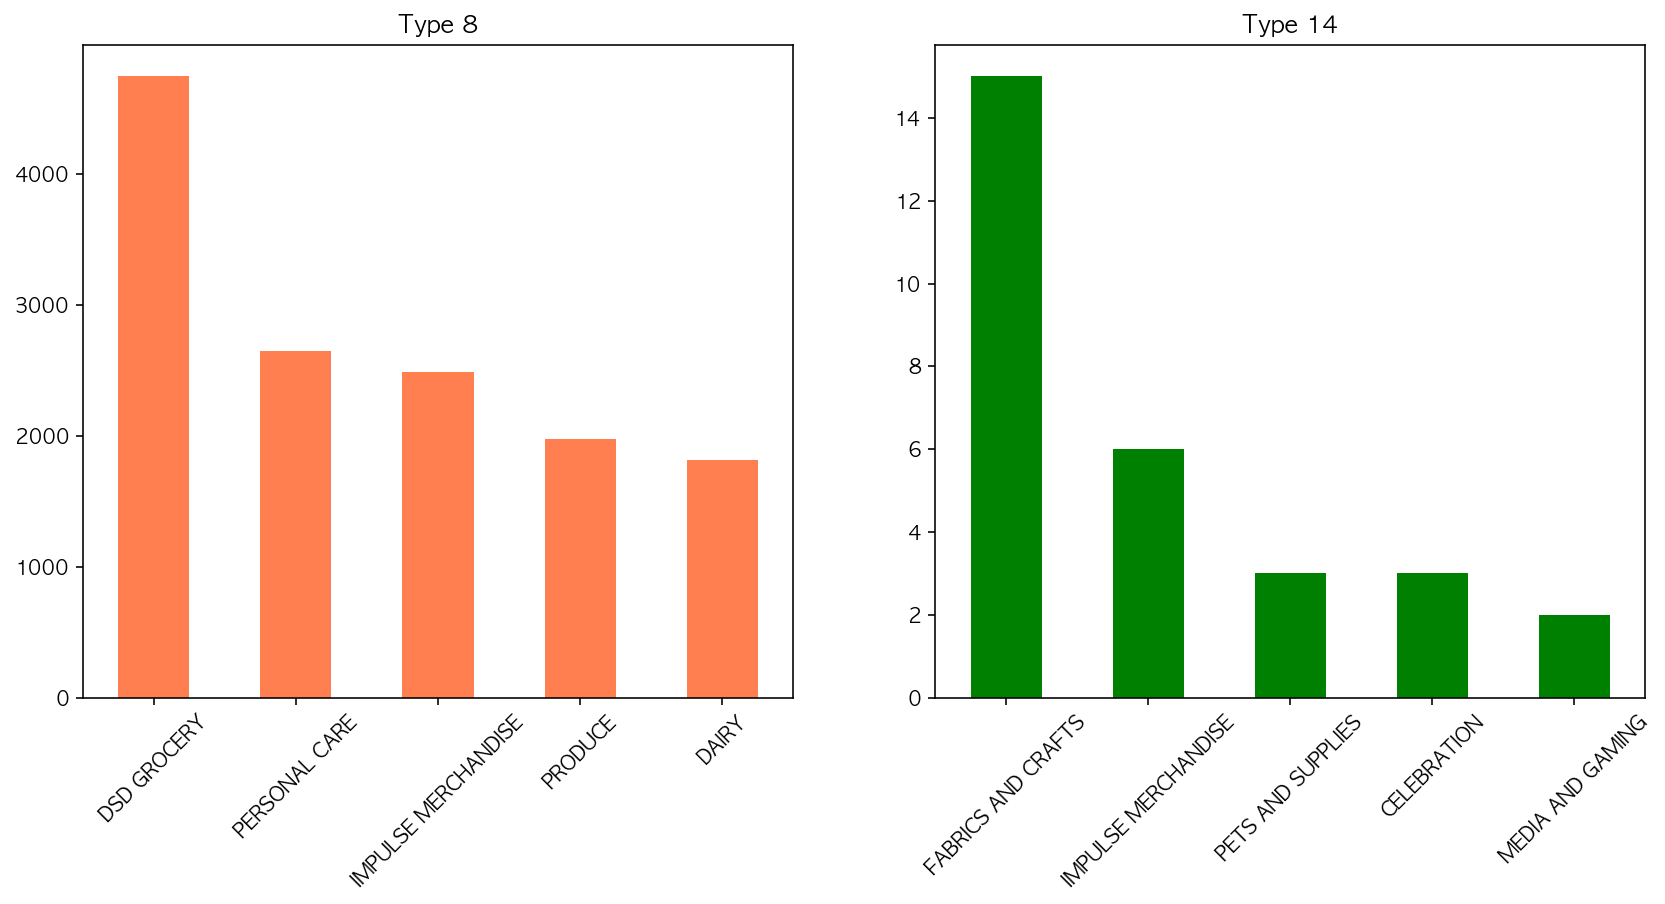

In [9]:
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121)
type_8 = train[train.TripType == 8]
type_8_items = type_8[["TripType","DepartmentDescription"]]
type_8_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                        title="Type 8", color="coral")
ax1 = fig.add_subplot(122)
type_14 = train[train.TripType == 14]
type_14_items = type_14[["TripType","DepartmentDescription"]]
type_14_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                        title="Type 14", color="green")
plt.xticks(fontsize=10)
plt.show()

- 가장 많은 TripType과 적은 TripType에서 등장하는 DepartmentDescription의 차이 존재
- 하나의 Department에서만 구매한 것이 아닌 여러 Department에서 구매함


- Feature Engineering에서 DepartmentDescription Encoding과 Multi-Single Department 여부 반영 (Dummy, CategoryCounts)

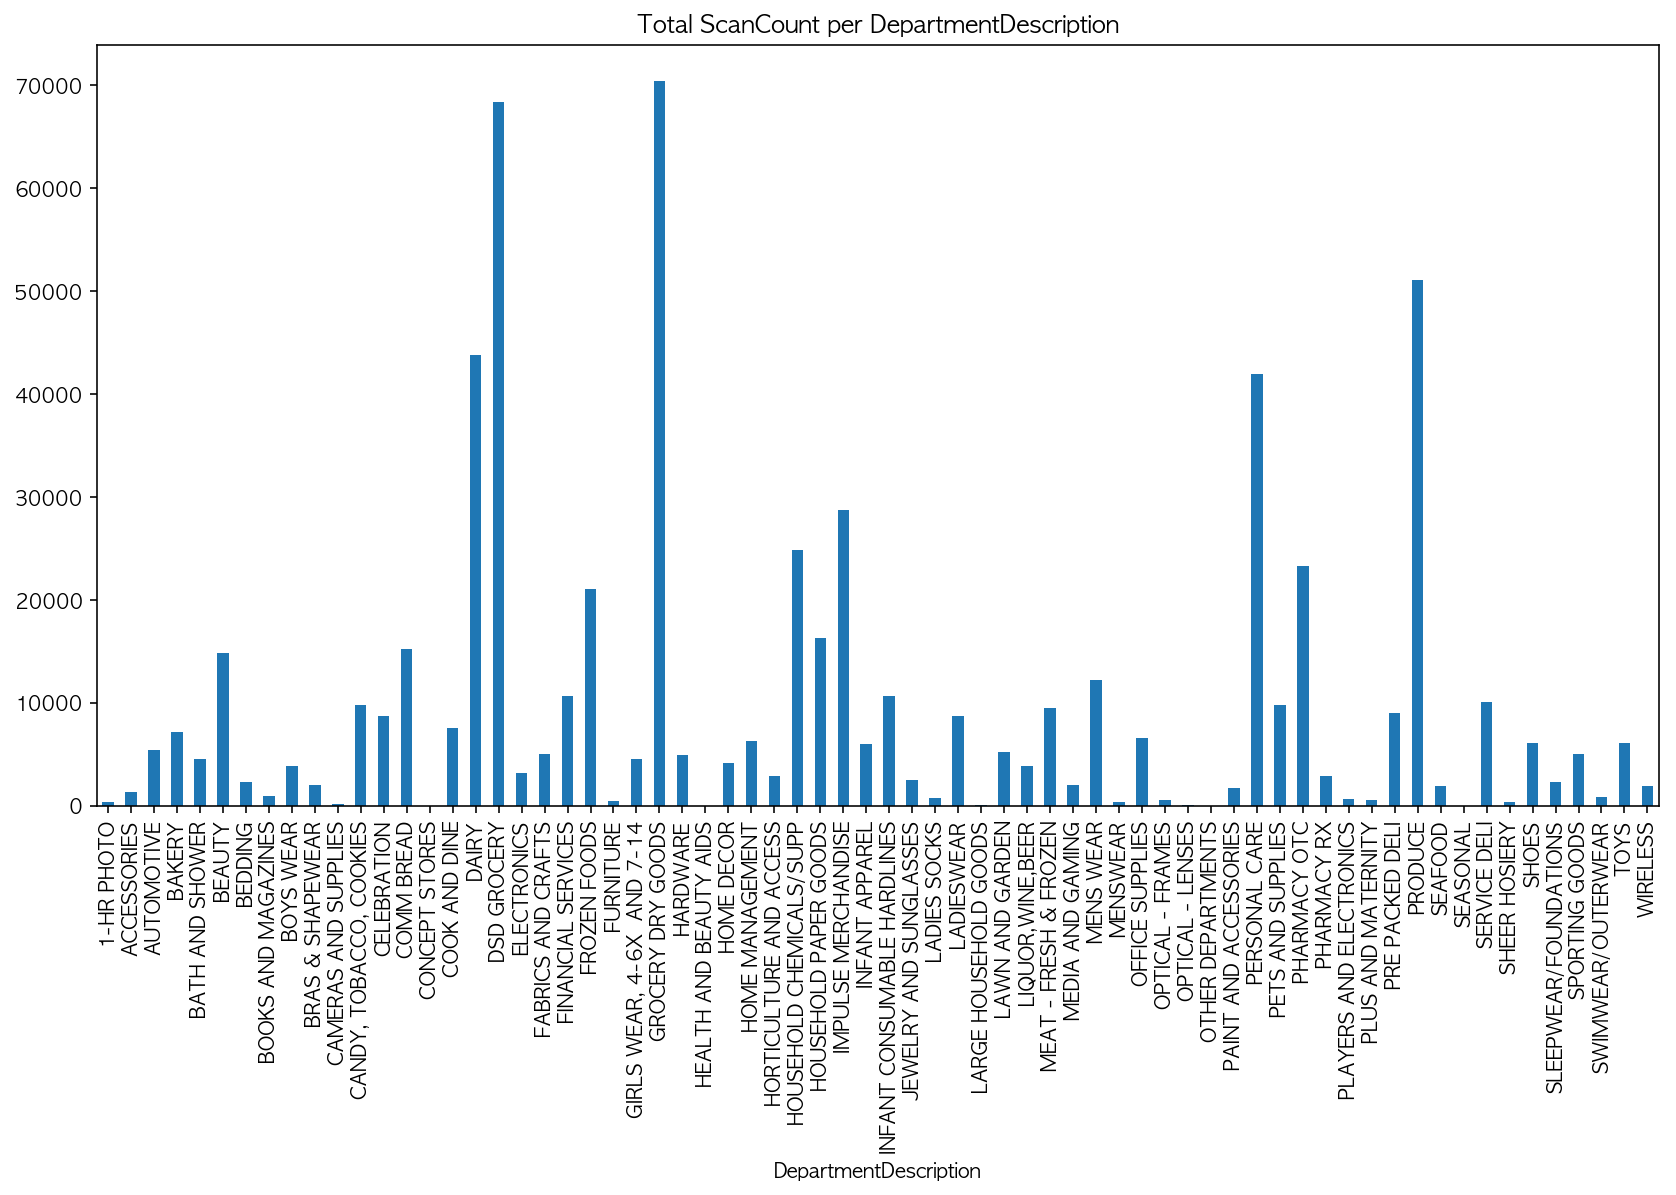

In [15]:
plt.figure(figsize=(14, 7))

# Plot total number of DepartmentDescriptions
train.groupby(['DepartmentDescription'], as_index=False).size().plot('bar')
plt.title("Total ScanCount per DepartmentDescription")

plt.show()

- 방문객들이 많이 방문하는 Department는 식료품, 생활용품
- 복수의 Department 방문 여부를 Feature에 반영 (CategoryCounts)

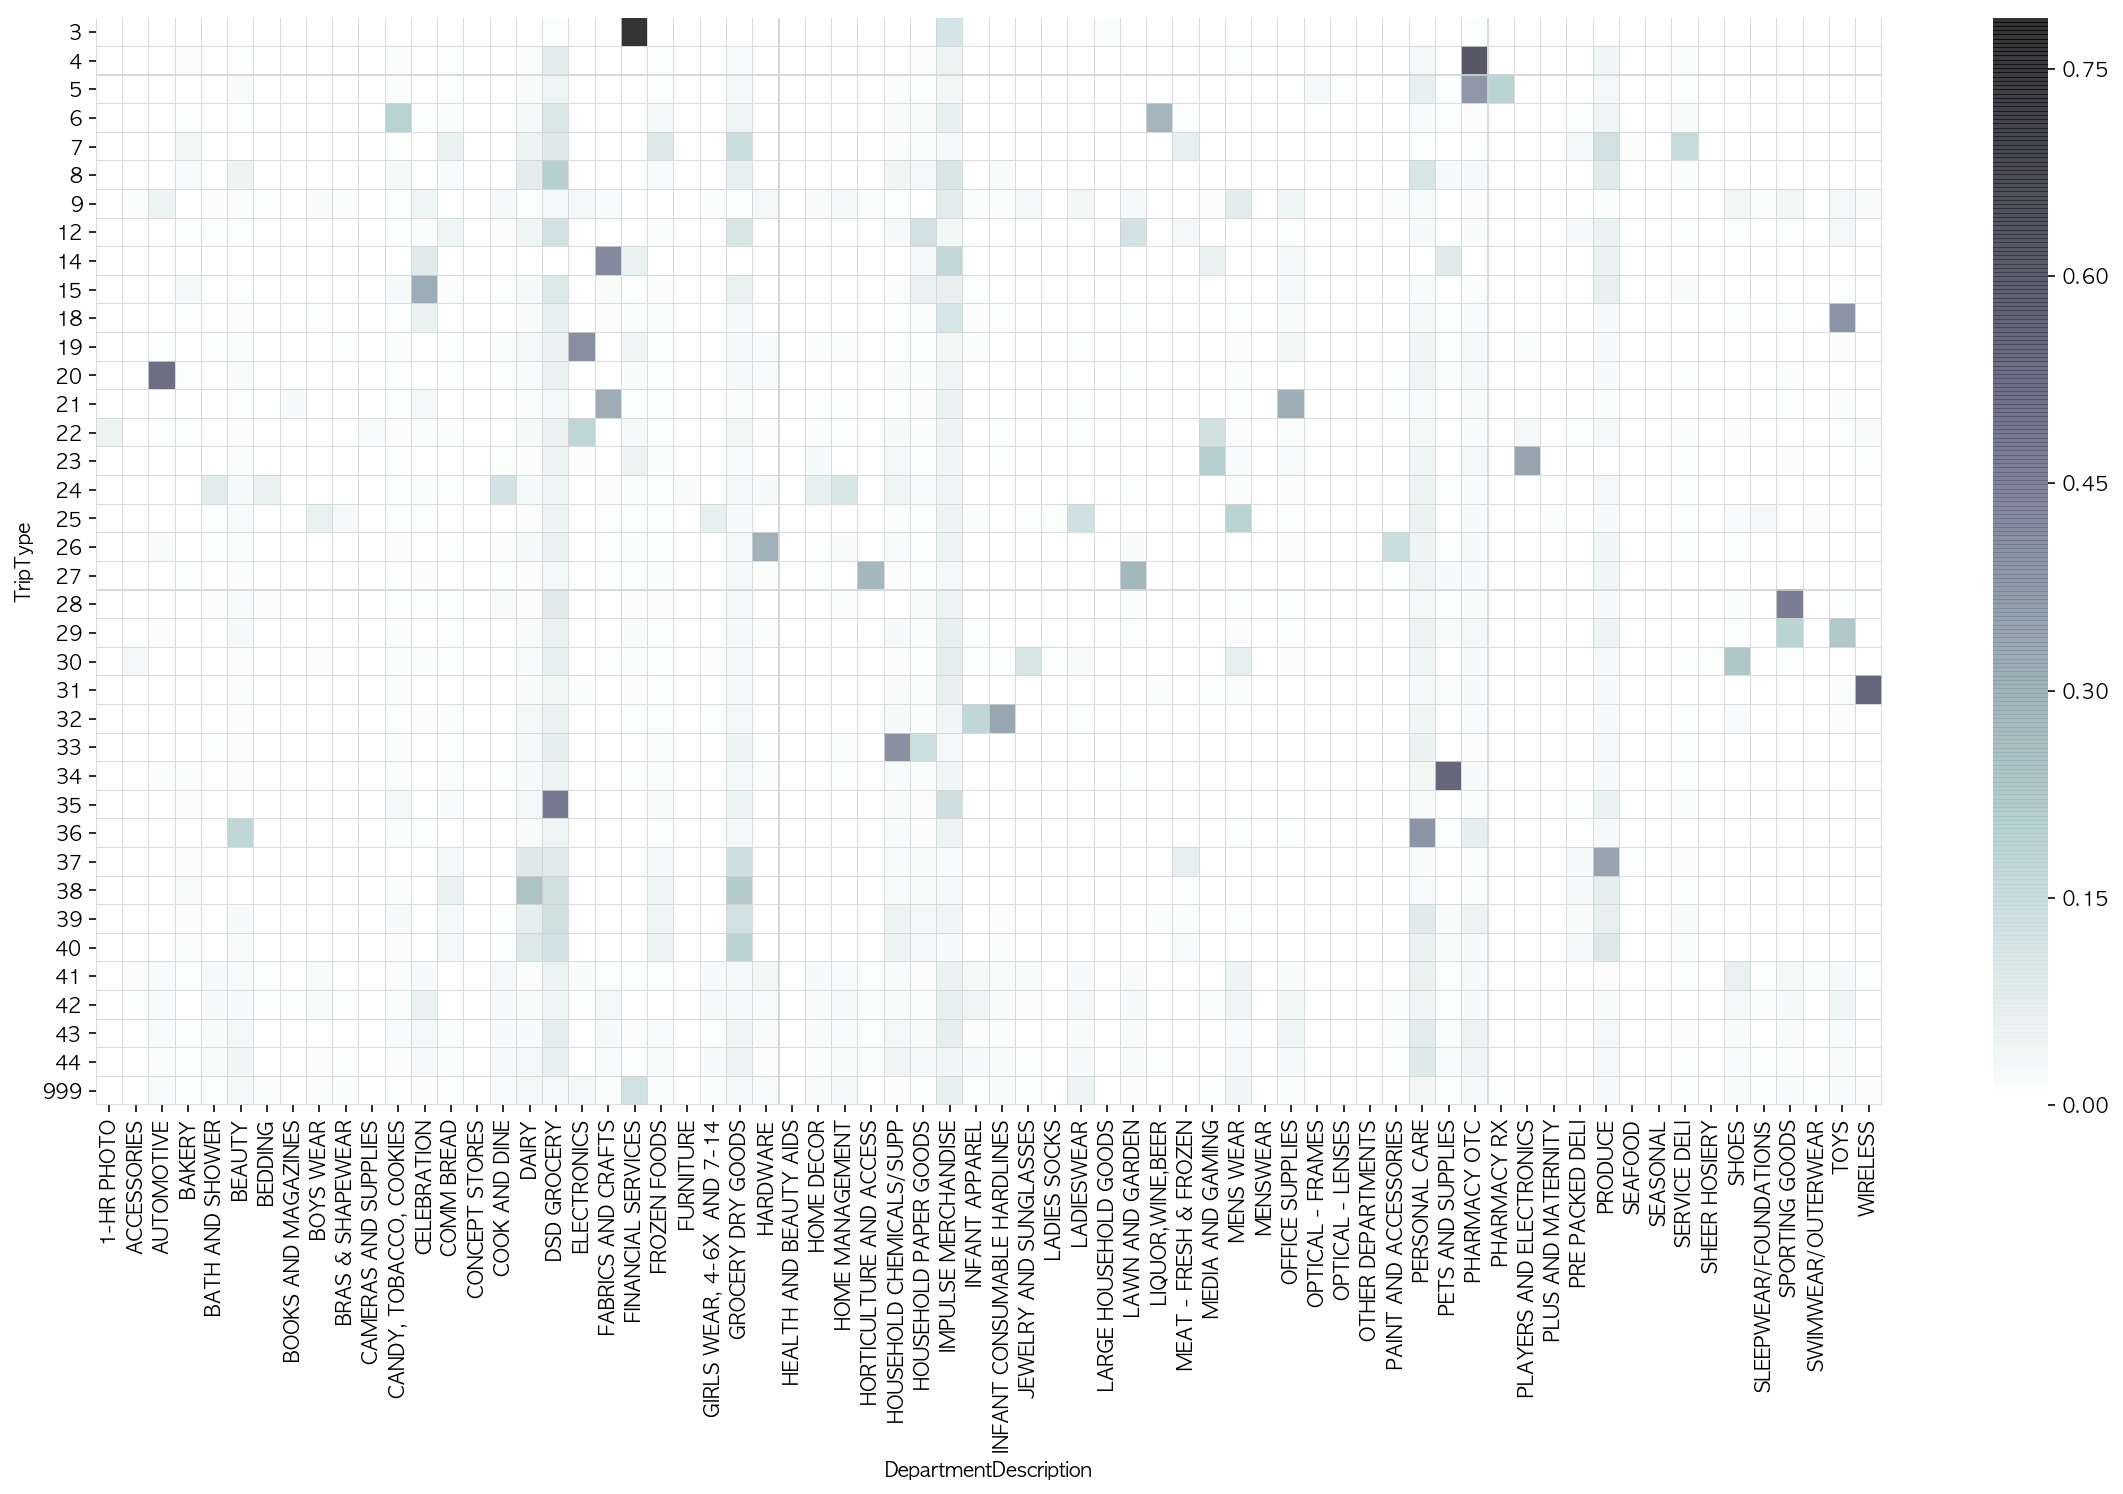

In [12]:
trip_desc = pd.crosstab(train["TripType"], 
                        train["DepartmentDescription"], 
                        values=train["ScanCount"], 
                        aggfunc="count", 
                        normalize="index")

plt.figure(figsize=(20, 10))
sns.heatmap(trip_desc, linecolor="lightgrey", linewidths=0.02, cmap=plt.cm.bone_r, alpha=.8)

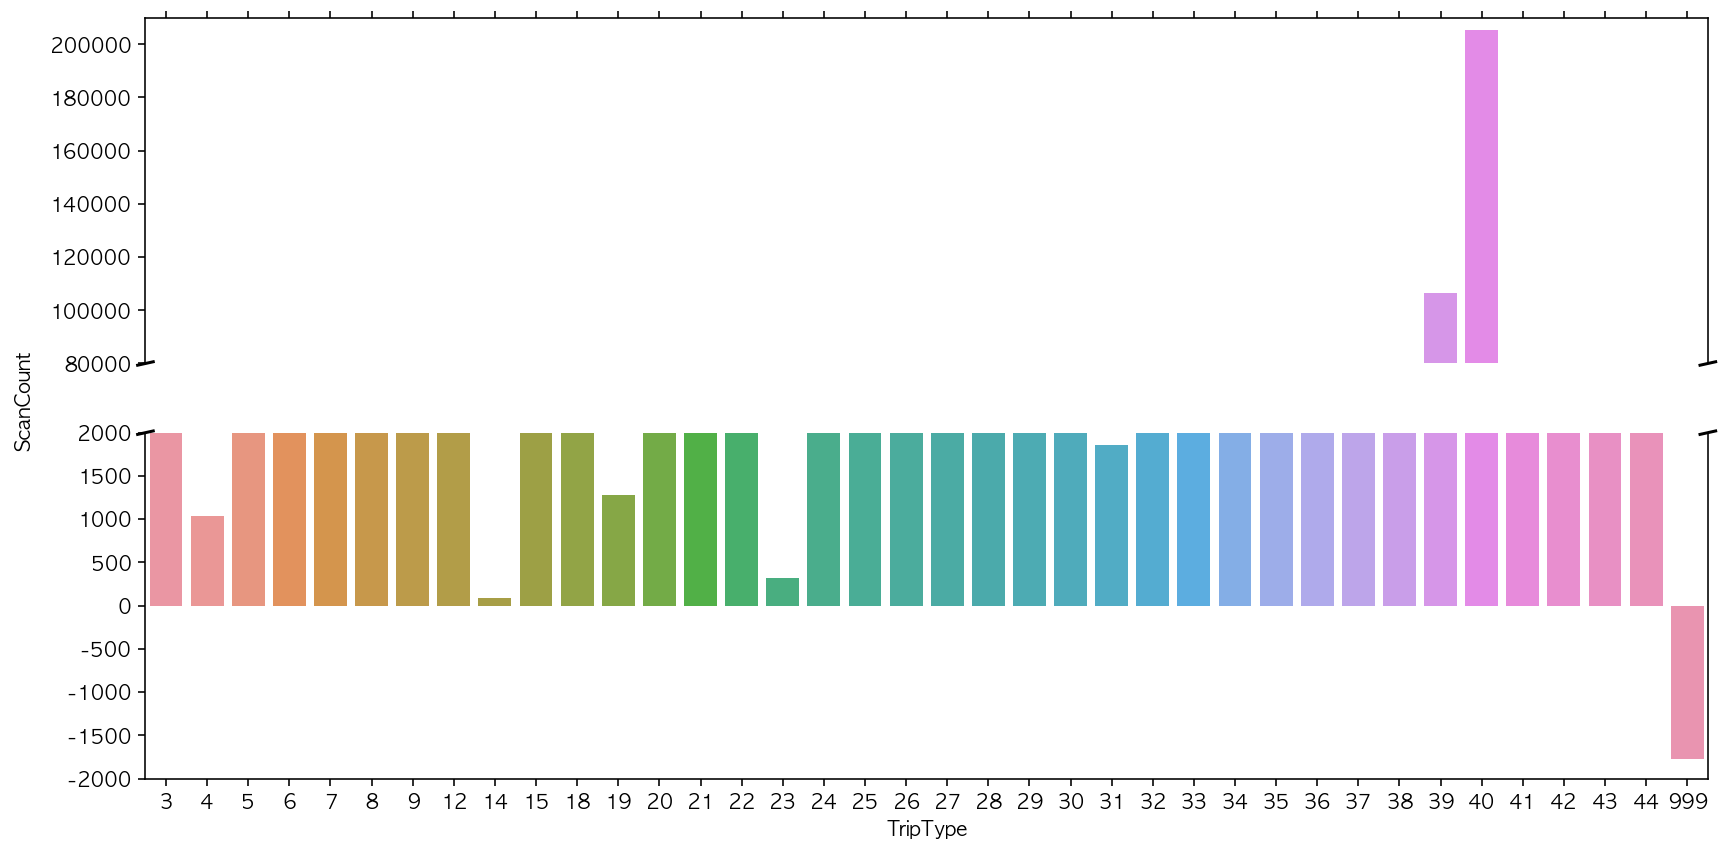

In [22]:
train_plot = train[["TripType", "ScanCount"]]
plot_grouped = train_plot.groupby("TripType", as_index=False).sum()

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 7))
sns.barplot(x="TripType", y="ScanCount", data=plot_grouped, ax=ax)
sns.barplot(x="TripType", y="ScanCount", data=plot_grouped, ax=ax2)

ax.set_ylim(80000, 210000)
ax2.set_ylim(-2000, 2000)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
ax2.yaxis.label.set_visible(False)

f.text(0.06, 0.5, 'ScanCount', va='center', rotation='vertical')

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .005

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  

kwargs.update(transform=ax2.transAxes) 
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs) 

plt.show()

- TripType 999는 반품을 위한 방문이라고 생각됨
- Return 여부를 Feature에 반영 (Return)
- ScanCount를 실제 판매수량과 반품으로 나누어서 Feature에 반영 (Pos_Sum, Neg_Sum)

# [ Preprocessing ]

### UPC company code 분리

In [14]:
train["Upc"] = train.Upc.apply(float_to_str)
test["Upc"] = test.Upc.apply(float_to_str)

train["company"] = train.Upc.apply(company) 
test["company"] = test.Upc.apply(company)

In [15]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000.0,681131
1,30,7,Friday,60538815980,1,SHOES,8931.0,605388
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504.0,741081
3,26,8,Friday,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840
4,26,8,Friday,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661


### Return 발생 여부 표기

In [16]:
train.loc[train["ScanCount"] < 0, "Return"] = 1
train.loc[train["Return"] != 1, "Return"] = 0

test.loc[test["ScanCount"] < 0, "Return"] = 1
test.loc[test["Return"] != 1, "Return"] = 0

In [17]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0
1,30,7,Friday,60538815980,1,SHOES,8931.0,605388,0.0
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504.0,741081,0.0
3,26,8,Friday,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0
4,26,8,Friday,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0


### Weekday 인코딩

In [18]:
wd = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, 
      "Friday": 4, "Saturday": 5, "Sunday": 6}

train["Weekday"] = train["Weekday"].apply(lambda x: wd[x])
test["Weekday"] = test["Weekday"].apply(lambda x: wd[x])

In [19]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return
0,999,5,4,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0
1,30,7,4,60538815980,1,SHOES,8931.0,605388,0.0
2,30,7,4,7410811099,1,PERSONAL CARE,4504.0,741081,0.0
3,26,8,4,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0
4,26,8,4,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0


### 실제 판매 수량

In [20]:
train["Pos_Sum"] = train["ScanCount"]
test["Pos_Sum"] = test["ScanCount"]

train.loc[train["Pos_Sum"] < 0, "Pos_Sum"] = 0
test.loc[test["Pos_Sum"] < 0, "Pos_Sum"] = 0

In [21]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return,Pos_Sum
0,999,5,4,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0,0
1,30,7,4,60538815980,1,SHOES,8931.0,605388,0.0,1
2,30,7,4,7410811099,1,PERSONAL CARE,4504.0,741081,0.0,1
3,26,8,4,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0,2
4,26,8,4,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0,2


### 반품 수량

In [22]:
train["Neg_Sum"] = train["ScanCount"]
test["Neg_Sum"] = test["ScanCount"]

train.loc[train["Neg_Sum"] > 0, "Neg_Sum"] = 0
test.loc[test["Neg_Sum"] > 0, "Neg_Sum"] = 0

In [23]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return,Pos_Sum,Neg_Sum
0,999,5,4,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0,0,-1
1,30,7,4,60538815980,1,SHOES,8931.0,605388,0.0,1,0
2,30,7,4,7410811099,1,PERSONAL CARE,4504.0,741081,0.0,1,0
3,26,8,4,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0,2,0
4,26,8,4,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0,2,0


### UPC Check Digit 추가

In [24]:
train["check"] = train.Upc.apply(check_digit)
test["check"] = test.Upc.apply(check_digit)

In [25]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return,Pos_Sum,Neg_Sum,check
0,999,5,4,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0,0,-1,7
1,30,7,4,60538815980,1,SHOES,8931.0,605388,0.0,1,0,9
2,30,7,4,7410811099,1,PERSONAL CARE,4504.0,741081,0.0,1,0,2
3,26,8,4,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0,2,0,2
4,26,8,4,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0,2,0,1


# [ Feature Engineering ]

### VisitNumber 별 가장 빈도가 잦은 FinelineNumber

In [26]:
# new feature

train_fineline = train[["VisitNumber", "FinelineNumber"]]
train_fineline = train_fineline.groupby("VisitNumber", as_index=False).agg(mode)
train_fineline.rename(columns={"FinelineNumber": "MF_FinelineNumber"}, inplace=True)

test_fineline = test[["VisitNumber", "FinelineNumber"]]
test_fineline = test_fineline.groupby("VisitNumber", as_index=False).agg(mode)
test_fineline.rename(columns={"FinelineNumber": "MF_FinelineNumber"}, inplace=True)

### VisitNumber 별 

In [27]:
train_upc_fine = train[["VisitNumber", "Upc", "FinelineNumber"]]
test_upc_fine = test[["VisitNumber", "Upc", "FinelineNumber"]]

train_upc_fine_group = train_upc_fine.groupby("VisitNumber", as_index=False).count()
train_upc_fine_group.rename(columns={"Upc": "N_Upc", 
                                     "FinelineNumber": "N_FinelineNumber"}, inplace=True)
test_upc_fine_group = test_upc_fine.groupby("VisitNumber", as_index=False).count()
test_upc_fine_group.rename(columns={"Upc": "N_Upc", 
                                    "FinelineNumber": "N_FinelineNumber"}, inplace=True)

In [28]:
train_upc_fine_group.head()

,VisitNumber,N_Upc,N_FinelineNumber
0,5,1,1
1,7,2,2
2,8,23,22
3,9,3,3
4,10,3,3


In [29]:
train = train.drop(["Upc", "FinelineNumber"], axis=1)
test = test.drop(["Upc", "FinelineNumber"], axis=1)

### DepartmentDescription의 더미변수 생성

In [30]:
train_dd = pd.get_dummies(train["DepartmentDescription"])
test_dd = pd.get_dummies(test["DepartmentDescription"])

train_dd = pd.concat([train[["VisitNumber"]], train_dd], axis=1)
test_dd = pd.concat([test[["VisitNumber"]], test_dd], axis=1)

train_dd = train_dd.groupby("VisitNumber", as_index=False).sum()
test_dd = test_dd.groupby("VisitNumber", as_index=False).sum()

In [31]:
train_dd.head()

,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 각 VisitNumber별 가장 많이 구매한 제품의 기업 코드

In [32]:
train_company = train[["VisitNumber", "company"]]
test_company = test[["VisitNumber", "company"]]

train_company = train_company.groupby("VisitNumber", as_index=False).agg(mode)
test_company = test_company.groupby("VisitNumber", as_index=False).agg(mode)

In [33]:
train_company.head()

,VisitNumber,company
0,5,681131
1,7,605388
2,8,223840
3,9,107008
4,10,641441


### 각 VisitNumber 별 가장 많이 구매한 제품의 Check Digit

In [34]:
train_check = train[["VisitNumber", "check"]]
test_check = test[["VisitNumber", "check"]]

train_check = train_check.groupby("VisitNumber", as_index=False).agg(mode)
test_check = test_check.groupby("VisitNumber", as_index=False).agg(mode)

In [35]:
train_check.head()

,VisitNumber,check
0,5,7
1,7,9
2,8,5
3,9,4
4,10,8


### VisitNumber를 index로 하는 groupby & merge

In [36]:
train_by_sum = train[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]
test_by_sum = test[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]

train_by_sum = train_by_sum.groupby("VisitNumber", as_index=False).sum()
test_by_sum = test_by_sum.groupby("VisitNumber", as_index=False).sum()

train_by_max = train[["TripType", "VisitNumber", "Weekday", "Return"]]
test_by_max = test[["VisitNumber", "Weekday", "Return"]]

train_by_max = train_by_max.groupby("VisitNumber", as_index=False).max()
test_by_max = test_by_max.groupby("VisitNumber", as_index=False).max()

In [37]:
train = train_by_sum.merge(train_by_max, on=["VisitNumber"])
train = train.merge(train_dd, on=["VisitNumber"])
train = train.merge(train_company, on=["VisitNumber"])
train = train.merge(train_check, on=["VisitNumber"])
train = train.merge(train_fineline, on=["VisitNumber"])
train = train.merge(train_upc_fine_group, on=["VisitNumber"])

test = test_by_sum.merge(test_by_max, on=["VisitNumber"])
test = test.merge(test_dd, on=["VisitNumber"])
test = test.merge(test_company, on=["VisitNumber"])
test = test.merge(test_check, on=["VisitNumber"])
test = test.merge(test_fineline, on=["VisitNumber"])
test = test.merge(test_upc_fine_group, on=["VisitNumber"])

- ### test data에서는 발생하지 않는 DepartmentDescription 제거
- ### train & target 분리

In [39]:
y = train["TripType"]
train = train.drop(["TripType", "HEALTH AND BEAUTY AIDS"], axis=1)

### 각 VisitNumber 별 판매된 아이템의 DepartmentDescription 빈도

In [40]:
from walmart_utils import category_counts

In [41]:
%%time
train = category_counts(train)
test = category_counts(test)

CPU times: user 16.7 s, sys: 37.6 ms, total: 16.7 s
Wall time: 16.8 s


In [42]:
train.head()

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,Weekday,Return,CategoryCounts,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,company,check,MF_FinelineNumber,N_Upc,N_FinelineNumber
0,5,-1,0,-1,4,1.0,1,0,0,0,...,0,0,0,0,0,681131,7,1000.0,1,1
1,7,2,2,0,4,0.0,2,0,0,0,...,0,0,0,0,0,605388,9,8931.0,2,2
2,8,28,30,-2,4,1.0,6,0,0,0,...,0,0,0,0,0,223840,5,3565.0,23,22
3,9,3,3,0,4,0.0,2,0,0,0,...,0,0,0,0,0,107008,4,115.0,3,3
4,10,3,3,0,4,0.0,2,0,0,0,...,0,0,0,0,0,641441,8,2008.0,3,3


### VisitNumber 별로 발생한 FinelineNumber와 UPC의 비율

In [43]:
train["Upc_FLN"] = train["N_Upc"] / train["N_FinelineNumber"]
test["Upc_FLN"] = test["N_Upc"] / test["N_FinelineNumber"]

In [44]:
train.head()

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,Weekday,Return,CategoryCounts,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,company,check,MF_FinelineNumber,N_Upc,N_FinelineNumber,Upc_FLN
0,5,-1,0,-1,4,1.0,1,0,0,0,...,0,0,0,0,681131,7,1000.0,1,1,1.000000
1,7,2,2,0,4,0.0,2,0,0,0,...,0,0,0,0,605388,9,8931.0,2,2,1.000000
2,8,28,30,-2,4,1.0,6,0,0,0,...,0,0,0,0,223840,5,3565.0,23,22,1.045455
3,9,3,3,0,4,0.0,2,0,0,0,...,0,0,0,0,107008,4,115.0,3,3,1.000000
4,10,3,3,0,4,0.0,2,0,0,0,...,0,0,0,0,641441,8,2008.0,3,3,1.000000


### Weeday, Return의 더미변수 생성

In [45]:
train = pd.get_dummies(train, columns=["Weekday", "Return"])
test = pd.get_dummies(test, columns=["Weekday", "Return"])

In [46]:
train.head()

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,CategoryCounts,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,...,Upc_FLN,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Return_0.0,Return_1.0
0,5,-1,0,-1,1,0,0,0,0,0,...,1.000000,0,0,0,0,1,0,0,0,1
1,7,2,2,0,2,0,0,0,0,0,...,1.000000,0,0,0,0,1,0,0,1,0
2,8,28,30,-2,6,0,0,0,0,0,...,1.045455,0,0,0,0,1,0,0,0,1
3,9,3,3,0,2,0,0,0,0,0,...,1.000000,0,0,0,0,1,0,0,1,0
4,10,3,3,0,2,0,0,0,0,0,...,1.000000,0,0,0,0,1,0,0,1,0


In [47]:
train[np.isnan(train['MF_FinelineNumber']) == True]['MF_FinelineNumber'].unique()

array([ nan])

### Null Value, Inf Value

In [48]:
train.replace(np.inf, 0, inplace=True)
train.fillna(value=0, inplace=True)

test.replace(np.inf, 0, inplace=True)
test.fillna(value=0, inplace=True)

* * * *

# [ Model Generation ]

- XGBoost

In [49]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [50]:
label_enc = LabelEncoder().fit(y)
y_labeled = label_enc.transform(y)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    train, y_labeled, random_state=0)

In [52]:
dtrain = xgb.DMatrix(X_train.values, label=y_train)
dtest = xgb.DMatrix(X_test.values, label=y_test)

In [54]:
num_boost_round = 300
params = {'objective': 'multi:softprob', 
          'eval_metric': 'mlogloss',
          'num_class':38, 
          'max_delta_step': 3, 
          'eta': 0.2}

evals = [(dtrain, 'train'), (dtest, 'eval')]


bst = xgb.train(params=params,  
                dtrain=dtrain, 
                num_boost_round=num_boost_round, 
                evals=evals,
                early_stopping_rounds=10,)

[0]	train-mlogloss:3.06967	eval-mlogloss:3.07893
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:2.56653	eval-mlogloss:2.58828
[2]	train-mlogloss:2.16457	eval-mlogloss:2.20002
[3]	train-mlogloss:1.86821	eval-mlogloss:1.91287
[4]	train-mlogloss:1.67196	eval-mlogloss:1.72426
[5]	train-mlogloss:1.52676	eval-mlogloss:1.58645
[6]	train-mlogloss:1.41216	eval-mlogloss:1.47811
[7]	train-mlogloss:1.31653	eval-mlogloss:1.38905
[8]	train-mlogloss:1.23874	eval-mlogloss:1.31706
[9]	train-mlogloss:1.1726	eval-mlogloss:1.25624
[10]	train-mlogloss:1.1155	eval-mlogloss:1.20461
[11]	train-mlogloss:1.06653	eval-mlogloss:1.16044
[12]	train-mlogloss:1.02395	eval-mlogloss:1.12237
[13]	train-mlogloss:0.986287	eval-mlogloss:1.08959
[14]	train-mlogloss:0.953926	eval-mlogloss:1.0619
[15]	train-mlogloss:0.923181	eval-mlogloss:1.03601
[16]	train-mlogloss:0.897219	eval-mlogloss:1.01469
[17]	tra

##### logarithmic loss

In [56]:
from sklearn.metrics import log_loss
my_test = xgb.DMatrix(X_test.values)
test_predictions = bst.predict(my_test)
print("log loss :", log_loss(y_test, test_predictions).round(5))

log loss : 0.783


#### *Featue Importance*

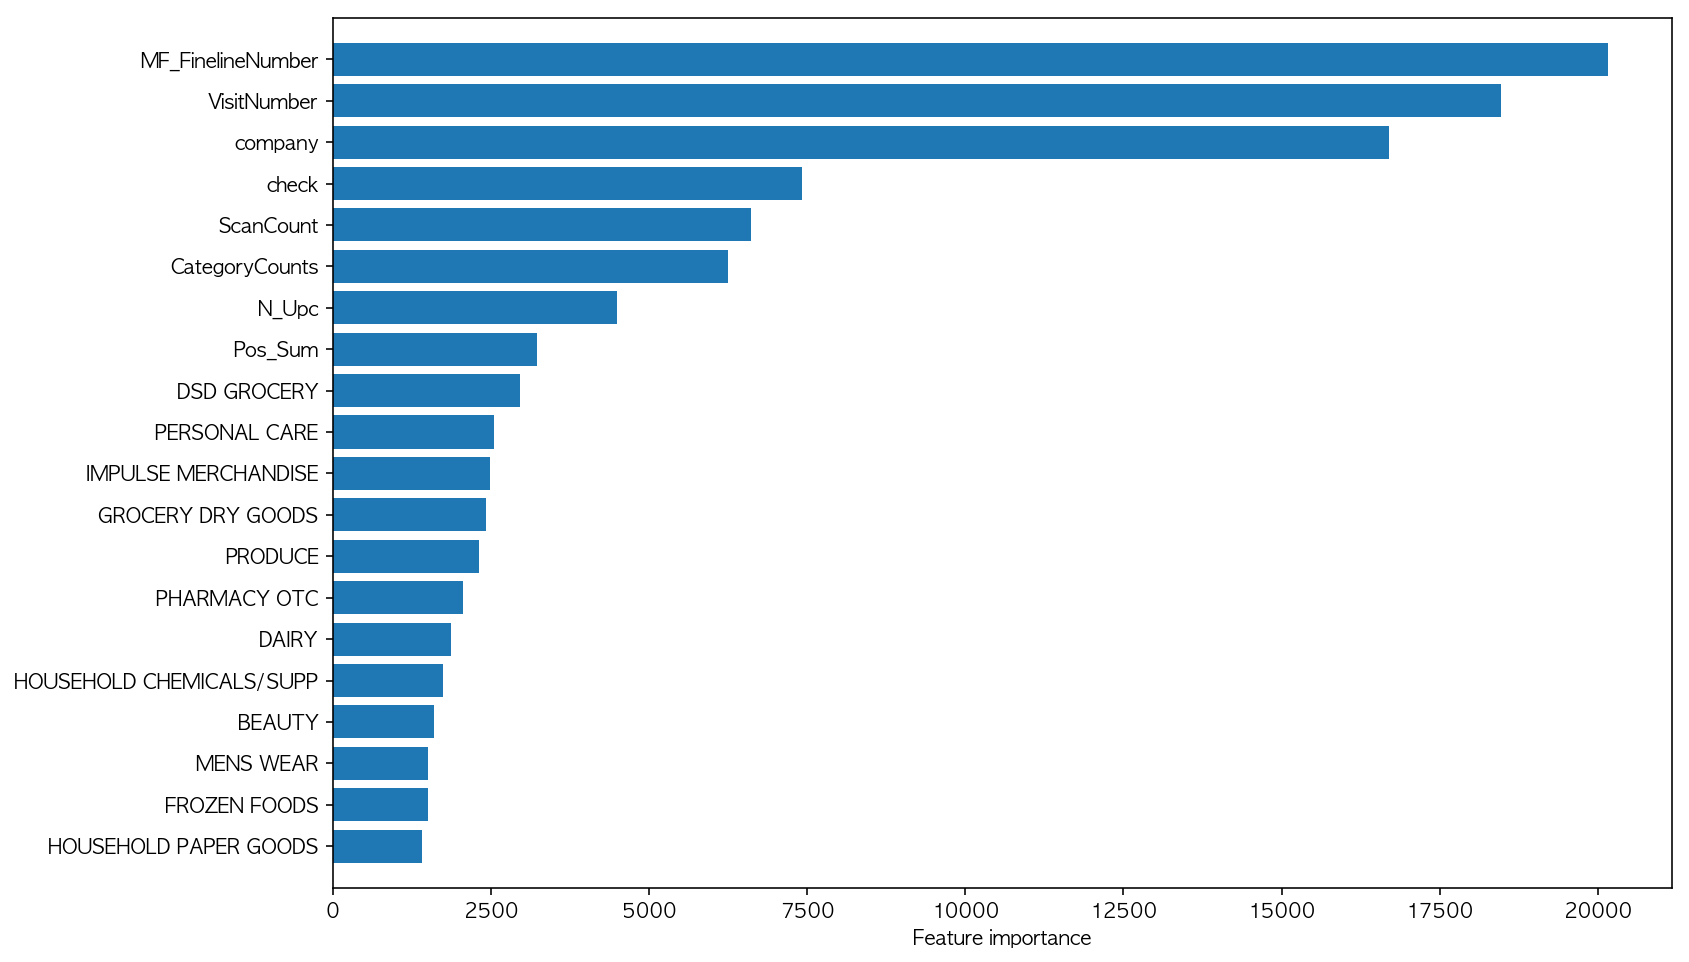

In [55]:
import operator
importance_dict = bst.get_score()
sorted_dict = sorted(importance_dict.items(), key=operator.itemgetter(1))
sorted_dict = sorted_dict[::-1]

indices = []
for i in range(len(sorted_dict)-1):
    indices.append(sorted_dict[i][0])
    
indices = [int(idx[1:]) for idx in indices]

importance_features = []
for idx in indices:
    importance_features.append(train.columns[idx])

importance = list(bst.get_score().values())
importance = sorted(importance)
importance = importance[::-1]

pairs = list(zip(importance, importance_features))
labels = [label[1] for label in pairs]

plt.figure(figsize=(12, 8))
plt.barh(range(20), importance[:20][::-1], align="center")
plt.yticks(np.arange(20), labels[:20][::-1])
plt.xlabel("Feature importance")
plt.ylim(-1, 20)
plt.show()

##### Accuracy score

In [57]:
yprob = test_predictions.reshape(y_test.shape[0], 38)
ylabel = np.argmax(yprob, axis=1)
accuracy = 100 *(1 - (sum(int(ylabel[i]) != y_test[i]
                         for i in range(len(y_test))) / float(len(y_test))))
print("TripType Accuracy = %.2f%%" % accuracy)

TripType Accuracy = 73.65%


#### *Submission*